# Heat Equation
============

On the domain $x\in[-1,1]$, we wish to solve the heat equation,

$$u_t(x,t) = u_{xx}(x,t),$$

with Neumann boundary conditions,

$$u_x(-1,t)=1=u_x(1,t),$$

and initial condition 

$$u(x,t) = 1+\cos(\pi x)+0.2\cos(5\pi x).$$

In the limit as $t\to\infty$, the solution should be an affine function with slope 1.

We discretize space using a spectral Chebyshev collocation method of polynomial order $N$ onto a Chebyshev-Gauss-Lobatto grid, and integrate in time with a fourth order Runge-Kutta method.

Results with $N=32$
-------------------

In [1]:
%matplotlib inline
#from plt_style import *
import heatnb as heat

Running heat.py with numpy (CPU-MKL)


In [2]:
T,X,U,ctime,err = heat.main(32,[0,3],1e-4)

In [3]:
from hellaPy import *
import pylab as plt
import numpy as np


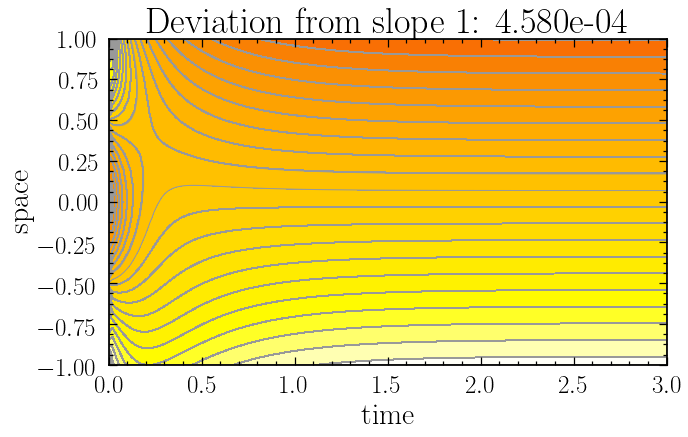

In [4]:
plt.figure(1,figsize=(10,6))
mycontourf(T,X,U,np.linspace(-1,1)*2.5,cmap=mycm15,edgecolor='#999999')
_=plt.xticks(fontsize=25)
_=plt.yticks(fontsize=25)
_=plt.xlabel('time',fontsize=30)
_=plt.ylabel('space',fontsize=30)
_=plt.title(f'Deviation from slope 1: {err:10.3e}',fontsize=36)